# CREDIT CARD ROUTING FOR ONLINE PURCHASE VIA PREDICTIVE MODELLING

In [11]:
# LIBRARIES IMPORTATIONS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from prince import MCA
from scipy import stats
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

In [12]:
# Define the file path
warnings.filterwarnings('ignore')
file_path = Path('PSP_Jan_Feb_2019.xlsx')

# Load the dataset
try:
    # Check and load file
    if file_path.is_file():
        data = pd.read_excel(file_path)
        print('File loaded successfully.')
    else:
        print(f'File {file_path} not found.')
        
except Exception as e:
    print(f'An error occurred: {e}')

File loaded successfully.


In [13]:
# Browse the dataset
data.set_index('ID', inplace = True)
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


,tmsp,country,amount,success,PSP,3D_secured,card
ID,,,,,,,
8910,2019-01-09 19:35:38,Switzerland,415,0,UK_Card,0,Master
49739,2019-02-28 04:16:47,Austria,84,1,UK_Card,0,Visa
10370,2019-01-11 09:25:13,Austria,188,0,Moneycard,1,Master
32240,2019-02-06 16:40:39,Austria,184,0,UK_Card,0,Diners
10293,2019-01-11 07:32:51,Germany,106,0,Moneycard,1,Visa
22293,2019-01-26 20:44:30,Germany,40,0,UK_Card,0,Diners
28083,2019-02-02 15:46:05,Germany,352,1,UK_Card,0,Diners
23192,2019-01-28 06:06:47,Germany,113,1,UK_Card,1,Visa
40024,2019-02-15 16:25:28,Austria,260,0,Simplecard,0,Master


## Data Preprocessing

### Data cleaning

In [14]:
# Check for null values
display(data.isnull().sum())

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [15]:
# Check for ~na values
display(data.notna().sum())

tmsp          50410
country       50410
amount        50410
success       50410
PSP           50410
3D_secured    50410
card          50410
dtype: int64

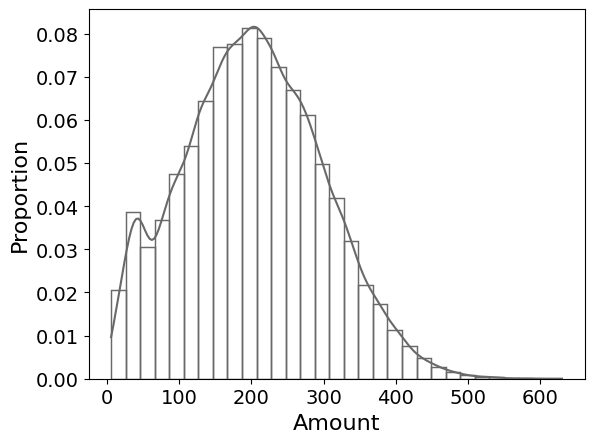

In [16]:
# Check for outliers
sns.histplot(data['amount'], stat='proportion', binwidth=20, kde=True, fill=False, color='dimgray')
plt.xlabel('Amount', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('transaction_amount_distribution.pdf', bbox_inches='tight', pad_inches=.1);

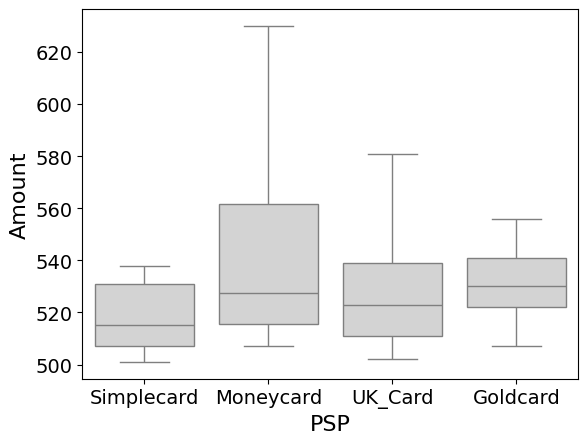

In [17]:
# Distribution of transaction amount per PSP
sns.boxplot(x='PSP', y='amount', data=data[data['amount']>500], color='lightgray')
plt.xlabel('PSP', fontsize=16)
plt.ylabel('Amount', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('transaction_amount_distribution_PSP.pdf', bbox_inches='tight', pad_inches=.1);

### Feature engineering

In [18]:
# Create a new feature for attempts count by grouping transactions with same country, amount, and timestamp difference<=1 min
data['tmsp'] = pd.to_datetime(data['tmsp'])
data = data.sort_values(by=['country', 'amount', 'tmsp'])
data['time_diff'] = data.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds().fillna(0)

data['attempt_count'] = 1
for i in range(1, len(data)):
    if (data.loc[i, 'country'] == data.loc[i-1, 'country']) and \
       (data.loc[i, 'amount'] == data.loc[i-1, 'amount']) and \
       (data.loc[i, 'time_diff'] <= 60):
        data.loc[i, 'attempt_count'] = data.loc[i-1, 'attempt_count'] + 1
    else:
        data.loc[i, 'attempt_count'] = 1

data.drop('time_diff', axis=1, inplace=True)
pd.DataFrame([data.attempt_count.value_counts(), data.attempt_count.value_counts(normalize=True)]).T

,count,proportion
attempt_count,,
1,27337.0,0.542293
2,12323.0,0.244455
3,5712.0,0.113311
4,2656.0,0.052688
5,1253.0,0.024856
6,612.0,0.012140
7,288.0,0.005713
8,144.0,0.002857
9,84.0,0.001666


In [19]:
# Filter out transactions where the maximum attempt count for a group is greater than 5
display('Proportion of transactions with more than 5 attempts: ', len(data[data['attempt_count'] > 5])/len(data))
attempt_counts = data.groupby(['country', 'amount'])['attempt_count'].transform('max')
data = data[data['attempt_count'] <= 5].reset_index(drop=True)
pd.DataFrame([data.attempt_count.value_counts(), data.attempt_count.value_counts(normalize=True)]).T

'Proportion of transactions with more than 5 attempts: '

0.022396349930569333

,count,proportion
attempt_count,,
1,27337.0,0.554717
2,12323.0,0.250056
3,5712.0,0.115907
4,2656.0,0.053895
5,1253.0,0.025426


In [20]:
# Convert timestamp to datetime for extracting hour and day of the week
data['hour'] = data['tmsp'].dt.hour.astype('int64')+1
data['day'] = data['tmsp'].dt.dayofweek.astype('int64')+1
data.drop('tmsp', axis=1, inplace=True)
data

,country,amount,success,PSP,3D_secured,card,attempt_count,hour,day
0,Austria,6,0,Moneycard,0,Diners,1,4,4
1,Austria,6,0,Simplecard,0,Diners,2,4,4
2,Austria,6,1,Simplecard,0,Master,1,15,7
3,Austria,6,0,UK_Card,0,Diners,1,6,5
4,Austria,6,0,UK_Card,0,Diners,2,6,5
...,...,...,...,...,...,...,...,...,...
49276,Switzerland,499,0,UK_Card,0,Master,1,5,4
49277,Switzerland,499,0,Simplecard,0,Master,2,5,4
49278,Switzerland,499,0,UK_Card,0,Master,3,5,4
49279,Switzerland,499,0,UK_Card,0,Master,4,5,4


In [21]:
# Data formating
for col in ['country', 'success', 'PSP', '3D_secured', 'card', 'attempt_count', 'day']:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   country        49281 non-null  category
 1   amount         49281 non-null  int64   
 2   success        49281 non-null  category
 3   PSP            49281 non-null  category
 4   3D_secured     49281 non-null  category
 5   card           49281 non-null  category
 6   attempt_count  49281 non-null  category
 7   hour           49281 non-null  int64   
 8   day            49281 non-null  category
dtypes: category(7), int64(2)
memory usage: 1.1 MB


## Exploratory Data Analysis

### Tables and Figures

In [22]:
# Statistical summary for qualitative variables
qualitative_variables = data.select_dtypes(include=['category']).columns

print('Categorical Variables Summary:\n')
for col in qualitative_variables:
    print(f'Summary for {col}:\n{data[col].value_counts(normalize=True)}\n')

Categorical Variables Summary:

Summary for country:
country
Germany        0.598973
Switzerland    0.205130
Austria        0.195897
Name: proportion, dtype: float64

Summary for success:
success
0    0.796757
1    0.203243
Name: proportion, dtype: float64

Summary for PSP:
PSP
UK_Card       0.523082
Simplecard    0.247276
Moneycard     0.165500
Goldcard      0.064142
Name: proportion, dtype: float64

Summary for 3D_secured:
3D_secured
0    0.760881
1    0.239119
Name: proportion, dtype: float64

Summary for card:
card
Master    0.575557
Visa      0.231022
Diners    0.193421
Name: proportion, dtype: float64

Summary for attempt_count:
attempt_count
1    0.554717
2    0.250056
3    0.115907
4    0.053895
5    0.025426
Name: proportion, dtype: float64

Summary for day:
day
2    0.169883
3    0.162395
4    0.154806
1    0.144153
5    0.137010
6    0.124632
7    0.107120
Name: proportion, dtype: float64



In [23]:
# Statistical summary for quantitative variables
quantitative_variables = data.select_dtypes(include=['int64']).columns
data[quantitative_variables].describe()

,amount,hour
count,49281.000000,49281.000000
mean,202.291309,12.504576
std,96.232718,6.919788
min,6.000000,1.000000
25%,133.000000,6.000000
50%,201.000000,13.000000
75%,269.000000,18.000000
max,630.000000,24.000000


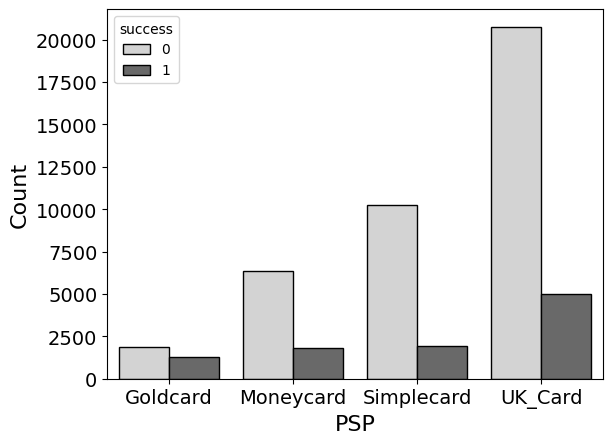

In [24]:
# Transaction Outcome per PSP
gray_palette = ['lightgray', 'dimgray']
sns.countplot(x='PSP', data=data, hue='success', palette=gray_palette, edgecolor='black')
plt.xlabel('PSP', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('transaction_outcome_PSP.pdf', bbox_inches='tight', pad_inches=.1);

In [25]:
# Success Rate per PSP
warnings.filterwarnings('ignore')
data.groupby('PSP')[['success']].value_counts(normalize=True)

PSP         success
Goldcard    0          0.594116
            1          0.405884
Moneycard   0          0.780530
            1          0.219470
Simplecard  0          0.841375
            1          0.158625
UK_Card     0          0.805648
            1          0.194352
Name: proportion, dtype: float64

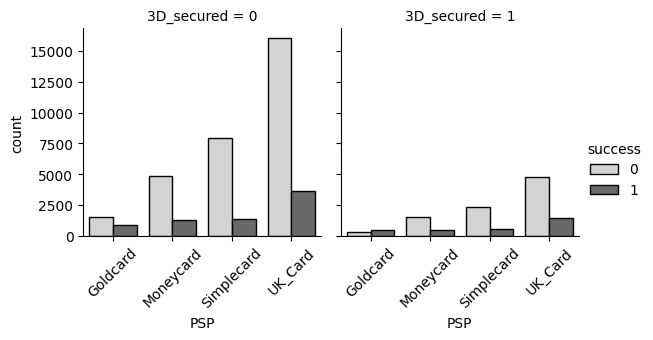

In [26]:
# Which factor determine transaction success for each PSP ? 3D_secured card...
sns.FacetGrid(data=data, col = '3D_secured',
              col_wrap=2).map_dataframe(sns.countplot, x='PSP', hue='success', edgecolor='black',
                                        palette=gray_palette).add_legend(title='success').set_xticklabels(rotation=45)
plt.savefig('transaction_outcome_PSP_3D.pdf', bbox_inches='tight', pad_inches=.1);

In [27]:
# Which factor determine transaction success for each PSP ? 3D_secured card...
warnings.filterwarnings('ignore')
grouped_data = data.groupby(['PSP', '3D_secured'])[['success']].value_counts(normalize=True).unstack()
grouped_data.columns = ['Failed', 'Succeeded']
grouped_data[['Succeeded']]

Succeeded
PSP        3D_secured           
Goldcard   0            0.348536
           1            0.583658
Moneycard  0            0.210917
           1            0.246436
Simplecard 0            0.147249
           1            0.194787
UK_Card    0            0.183507
           1            0.229089

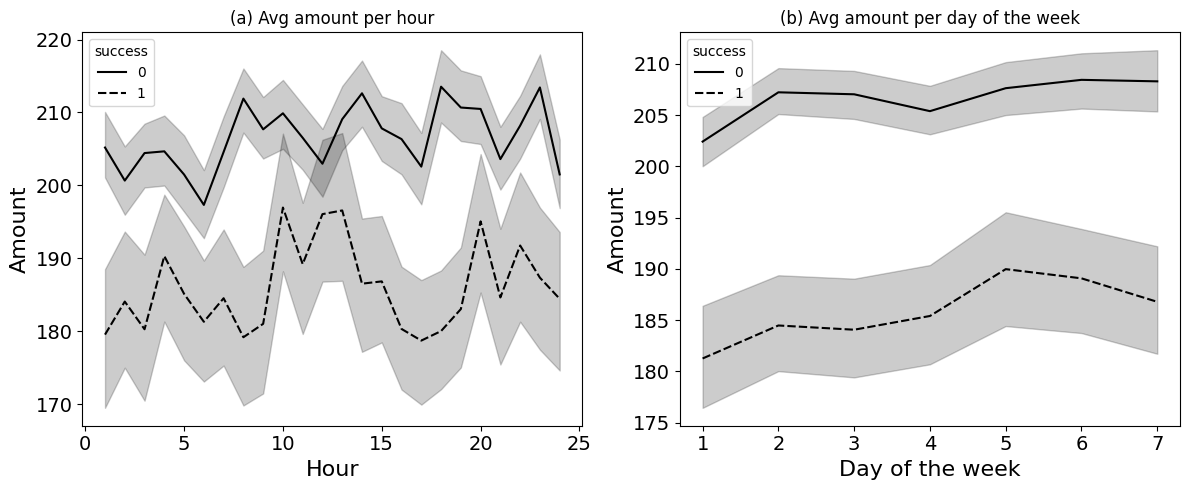

In [28]:
# Average transaction amount per hour and day of the week
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
black_palette = ['black', 'black']

sns.lineplot(data=data, x='hour', y='amount', hue='success', style='success', palette=black_palette, ax=ax1)
ax1.set_title('(a) Avg amount per hour')
ax1.set_xlabel('Hour', fontsize=16)
ax1.set_ylabel('Amount', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)

sns.lineplot(data=data, x='day', y='amount', hue='success', style='success', palette=black_palette, ax=ax2)
ax2.set_title('(b) Avg amount per day of the week')
ax2.set_xlabel('Day of the week', fontsize=16)
ax2.set_ylabel('Amount', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('transaction_amount.pdf', bbox_inches='tight', pad_inches=.1);

In [29]:
warnings.filterwarnings('ignore')
data.groupby('PSP')[['amount']].median()

,amount
PSP,
Goldcard,202.0
Moneycard,199.0
Simplecard,200.0
UK_Card,202.0


In [30]:
warnings.filterwarnings('ignore')
data.pivot_table(values='amount', columns='3D_secured', index='PSP', aggfunc='mean', margins=True)

3D_secured,0,1,All
PSP,,,
Goldcard,204.220502,201.343709,203.518823
Moneycard,202.070413,200.267312,201.636219
Simplecard,200.538511,203.622085,201.276383
UK_Card,202.803869,202.904614,202.827838
All,202.213004,202.540479,202.291309


PSP
UK_Card       0.523082
Simplecard    0.247276
Moneycard     0.165500
Goldcard      0.064142
Name: proportion, dtype: float64


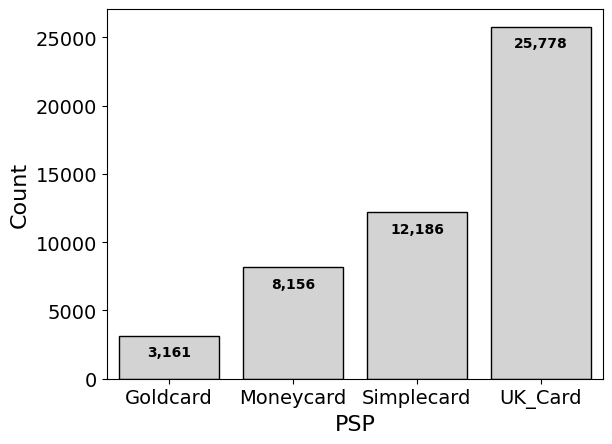

In [31]:
# Check for imbalanced dataset
print(data.PSP.value_counts(normalize=True))
classes = np.unique(data.PSP, return_counts=True)
classes = pd.DataFrame({'PSP':classes[0], 'Count':classes[1]})
bar_plot = sns.barplot(data=classes, x='PSP', y='Count', color='lightgray', edgecolor='black')
plt.xlabel('PSP', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
for i in range(len(classes['PSP'])):
    bar_plot.text(i, classes.iloc[i]['Count']-1500, f"{classes.iloc[i]['Count']:,}", ha='center', weight='bold')
plt.savefig('imbalanced_data.pdf', bbox_inches='tight', pad_inches=.1);

### Multiple Correspondance Analysis

In [32]:
# Preparing all categorical variables
qualitative_vars = data.drop(columns=['amount', 'hour'])
qualitative_vars.columns

Index(['country', 'success', 'PSP', '3D_secured', 'card', 'attempt_count',
       'day'],
      dtype='object')

In [33]:
# Function to perform chi-square test
def chi_square_tests(data, target_var):
    results = []
    for var in qualitative_vars.drop(target_var, axis=1).columns:
        cross_tab = data.pivot_table(values='amount', index=target_var, columns=var, aggfunc='count')
        khisq_stat, p_value, df, _ = stats.chi2_contingency(cross_tab)
        
        results.append({
            'Variable': var,
            'Target': target_var,
            'Chi-Square Statistic': khisq_stat,
            'P-value': p_value,
            'Degrees of Freedom': df
        })
    return pd.DataFrame(results)

In [34]:
# Run chi-square tests for PSP and success
khi_results_psp = chi_square_tests(data, 'success')
khi_results_success = chi_square_tests(data, 'PSP')
display(khi_results_psp)
display(khi_results_success)

,Variable,Target,Chi-Square Statistic,P-value,Degrees of Freedom
0,country,success,0.904008,6.363515e-01,2
1,PSP,success,977.225021,1.569148e-211,3
2,3D_secured,success,180.186280,4.413142e-41,1
3,card,success,42.183760,6.916922e-10,2
4,attempt_count,success,9.107492,5.846813e-02,4
5,day,success,50.864021,3.154059e-09,6


,Variable,Target,Chi-Square Statistic,P-value,Degrees of Freedom
0,country,PSP,7.183437,3.042158e-01,6
1,success,PSP,977.225021,1.569148e-211,3
2,3D_secured,PSP,0.733151,8.653803e-01,3
3,card,PSP,15.784259,1.495999e-02,6
4,attempt_count,PSP,426.800346,7.916299e-84,12
5,day,PSP,33.339523,1.517885e-02,18


In [35]:
# Performing MCA
mca = MCA(n_components=5, engine='sklearn', random_state=42).fit(qualitative_vars, y=data.amount)
mca_result = mca.transform(qualitative_vars)
mca_result.columns = ['Dim. ' + str(i) for i in np.arange(1,mca.n_components+1)]
mca_result

,Dim. 1,Dim. 2,Dim. 3,Dim. 4,Dim. 5
0,0.200651,-0.486992,-0.678911,0.232695,0.582932
1,-0.259594,-0.286325,-0.742836,-0.084720,0.678264
2,0.601440,-0.647999,-0.211188,0.232889,-0.358934
3,-0.073773,-0.083744,-0.662743,0.085836,0.337871
4,-0.324843,0.262948,-0.964047,-0.192239,0.260380
...,...,...,...,...,...
49276,-0.162229,-0.175328,-0.082277,-0.129889,0.608541
49277,-0.404431,-0.357146,-0.195352,-0.252664,0.641471
49278,-0.400311,0.287978,-0.239039,0.002803,0.640391
49279,-0.427963,0.384312,0.084582,0.013337,0.973549


In [36]:
# Displaying Eigenvalues and Explained Variance
mca_summary = mca.eigenvalues_summary
mca_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.170,6.25%,6.25%
1,0.155,5.72%,11.97%
2,0.148,5.45%,17.42%
3,0.146,5.39%,22.81%
4,0.145,5.33%,28.14%


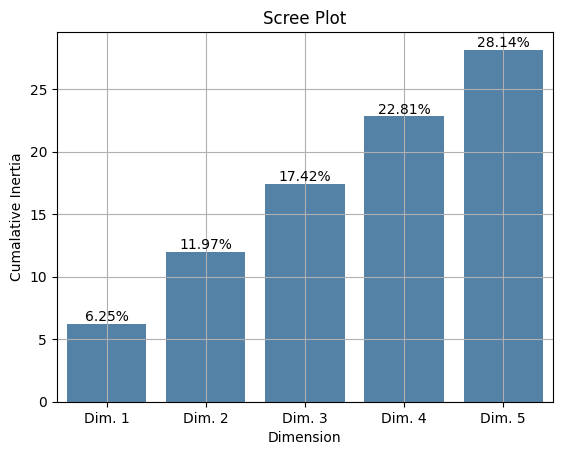

In [37]:
# Screeplot
inertia = mca.cumulative_percentage_of_variance_
scree_data = pd.DataFrame({
    'Dimension': ['Dim. ' + str(i) for i in np.arange(1,mca.n_components+1)],
    'Inertia': inertia
})
screeplot = sns.barplot(x='Dimension', y='Inertia', data=scree_data, color='steelblue')
plt.title('Scree Plot')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.grid()
plt.ylabel('Cumalative Inertia')
for index, row in scree_data.iterrows():
    screeplot.annotate(f"{row['Inertia']:.2f}%", 
                      (row['Dimension'], row['Inertia']), 
                      ha='center', va='bottom', 
                      color='black');

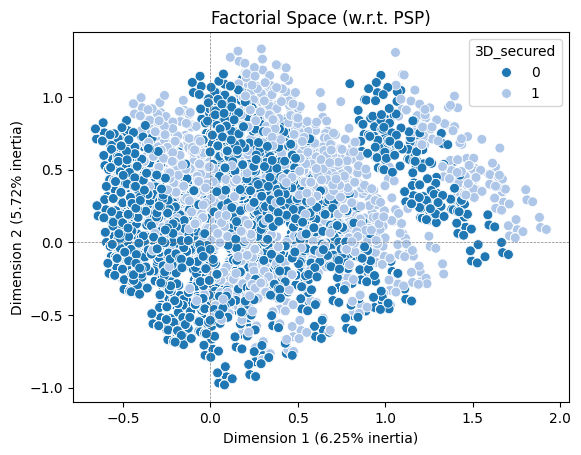

In [38]:
# Ploting rows in the component space w.r.t. PSP
sns.scatterplot(data=mca_result, x='Dim. 1', y='Dim. 2', hue=data['3D_secured'], palette='tab20', s=50)
plt.xlabel(f'Dimension 1 ({mca.percentage_of_variance_[0]:.2f}% inertia)')
plt.ylabel(f'Dimension 2 ({mca.percentage_of_variance_[1]:.2f}% inertia)')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.title('Factorial Space (w.r.t. PSP)');

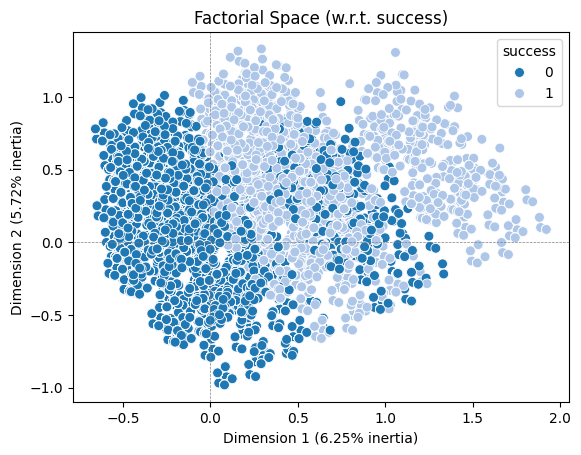

In [39]:
# Ploting rows in the component space w.r.t. success
sns.scatterplot(data=mca_result, x='Dim. 1', y='Dim. 2', hue=data['success'], palette='tab20', s=50)
plt.xlabel(f'Dimension 1 ({mca.percentage_of_variance_[0]:.2f}% inertia)')
plt.ylabel(f'Dimension 2 ({mca.percentage_of_variance_[1]:.2f}% inertia)')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.title('Factorial Space (w.r.t. success)');

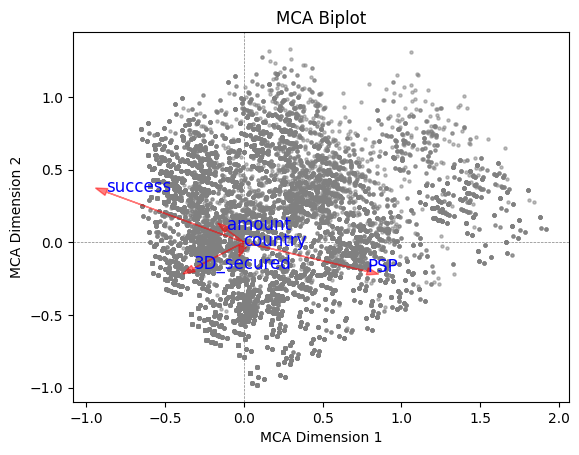

In [40]:
# MCA Biplot

# Get the coordinates for individuals and variables
individuals_coords = mca.row_coordinates(qualitative_vars)
variables_coords = mca.column_coordinates(qualitative_vars)

# Plot individuals
plt.scatter(individuals_coords[0], individuals_coords[1], alpha=0.5, label='Individuals', s=5, c='gray')

# Plot variable vectors
for i in range(variables_coords.shape[1]):
    plt.arrow(0, 0, variables_coords[i][0], variables_coords[i][1],
              color='red', alpha=0.5, head_width=0.05)
    variable_name = data.columns[i]
    plt.text(variables_coords[i][0], variables_coords[i][1], 
             variable_name, color='blue', fontsize=12)

# Add labels and title
plt.title('MCA Biplot')
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--');

In [41]:
# Variables contributions to the MCA dimensions
vars_contr = mca.column_contributions_
vars_contr.columns = ['Dim. ' + str(i) for i in np.arange(1,mca.n_components+1)]
display('Contributions to Dim. 1', vars_contr['Dim. 1'].sort_values(ascending=False).head(5))
display('Contributions to Dim. 2', vars_contr['Dim. 2'].sort_values(ascending=False).head(5))

'Contributions to Dim. 1'

PSP_Goldcard       0.290204
success_1          0.276822
success_0          0.070614
attempt_count_1    0.049288
3D_secured_1       0.045545
Name: Dim. 1, dtype: float64

'Contributions to Dim. 2'

PSP_Simplecard     0.193025
attempt_count_1    0.139336
PSP_UK_Card        0.138621
success_1          0.092318
attempt_count_3    0.060858
Name: Dim. 2, dtype: float64

## Modelling

In [42]:
# Keeping true labels of the target variable
y_label = data.PSP.unique()
y_label

['Moneycard', 'Simplecard', 'UK_Card', 'Goldcard']
Categories (4, object): ['Goldcard', 'Moneycard', 'Simplecard', 'UK_Card']

In [43]:
# Encoding categorical variables
categorical_cols = ['country', 'card', 'PSP']
for col in categorical_cols:
    data[col] = pd.Categorical(LabelEncoder().fit_transform(data[col]))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   country        49281 non-null  category
 1   amount         49281 non-null  int64   
 2   success        49281 non-null  category
 3   PSP            49281 non-null  category
 4   3D_secured     49281 non-null  category
 5   card           49281 non-null  category
 6   attempt_count  49281 non-null  category
 7   hour           49281 non-null  int64   
 8   day            49281 non-null  category
dtypes: category(7), int64(2)
memory usage: 1.1 MB


In [44]:
# Define features and target
X = data.drop(['PSP'], axis=1)
y = data['PSP']

In [45]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display('Distribution before resampling', pd.DataFrame([y_train.value_counts(), y_train.value_counts(normalize=True)]).T)

'Distribution before resampling'

,count,proportion
PSP,,
3,20566.0,0.521662
2,9794.0,0.248427
1,6534.0,0.165737
0,2530.0,0.064174


In [46]:
# Double resampling on the training set to handle imbalanced classes
resampling = SMOTEENN(sampling_strategy = 'all', random_state = 42)
X_train, y_train = resampling.fit_resample(X_train, y_train)
X_train, y_train = resampling.fit_resample(X_train, y_train)
display('Distribution after resampling', pd.DataFrame([y_train.value_counts(), y_train.value_counts(normalize=True)]).T)

'Distribution after resampling'

,count,proportion
PSP,,
0,11726.0,0.254730
1,11500.0,0.249821
2,11444.0,0.248604
3,11363.0,0.246845


### Baseline model: Logistic Regression

In [47]:
# Scaling the quantitative variable
X_train_scaled = X_train.copy()
X_train_scaled['scaled_amount'] = StandardScaler().fit_transform(X_train_scaled[['amount']])
X_train_scaled.drop('amount', axis=1, inplace=True)

X_test_scaled = X_test.copy()
X_test_scaled['scaled_amount'] = StandardScaler().fit_transform(X_test_scaled[['amount']])
X_test_scaled.drop('amount', axis=1, inplace=True)

In [48]:
# Hyperparameter tuning with cross validation
hyper_param = {
    'C': np.logspace(-2, 2, 5),
    'penalty': ['l1', 'l2', 'elasticnet']
}
Grid_baseline = GridSearchCV(LogisticRegression(class_weight='balanced', multi_class='ovr',
                                                solver='saga', n_jobs=-1), param_grid=hyper_param, cv=5)
Grid_baseline.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='ovr', n_jobs=-1,
                                          solver='saga'),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

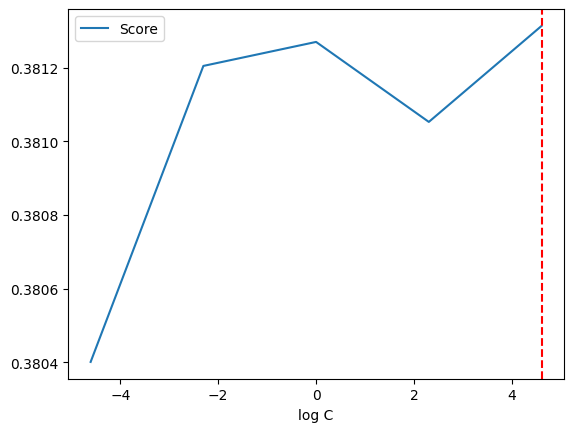

In [49]:
# Tuning process
C_values = np.logspace(-2, 2, 5)
score_train,score_cv=validation_curve(LogisticRegression(class_weight='balanced', multi_class='ovr', solver='saga'),
                                      X_train_scaled, y_train, param_name='C', param_range=C_values, cv=5, n_jobs=-1)
score_cv = pd.DataFrame(score_cv.mean(axis=1), columns=['Score'])
score_cv.set_index(np.log(C_values), inplace=True)
score_cv.index.names = ['log C']

sns.lineplot(data = score_cv).axvline(score_cv['Score'].idxmax(), color = 'red', linestyle = 'dashed');

In [50]:
# Best hyperparameters and Train score
display(Grid_baseline.best_params_)
print('Validation Score: ', Grid_baseline.best_score_)
baseline_model = Grid_baseline.best_estimator_
print('Train Score: ', baseline_model.score(X_train_scaled, y_train))

{'C': 0.01, 'penalty': 'l1'}

Validation Score:  0.38233448885968635
Train Score:  0.38576673256142335


In [51]:
# Feature coefficients and odds for interpretability
feature_names = X_train_scaled.columns
all_feature_importance = []

for i, class_coefficients in enumerate(baseline_model.coef_):
    odds_ratios = np.exp(class_coefficients)
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': class_coefficients,
        'Odds Ratio': odds_ratios,
        'Class': y_label[i]
    }).sort_values(by='Feature', ascending=False)
    
    all_feature_importance.append(feature_importance)

# Concatenate results for all classes
feature_importance_df = pd.concat(all_feature_importance, ignore_index=True)
feature_importance_df

,Feature,Coefficient,Odds Ratio,Class
0,success,1.381786e+00,3.982006,Moneycard
1,scaled_amount,0.000000e+00,1.000000,Moneycard
2,hour,-3.101241e-03,0.996904,Moneycard
3,day,-3.037051e-02,0.970086,Moneycard
4,country,-5.231895e-02,0.949026,Moneycard
5,card,-2.158339e-01,0.805869,Moneycard
6,attempt_count,-4.195894e-01,0.657317,Moneycard
7,3D_secured,-2.993680e-01,0.741287,Moneycard
8,success,-3.478977e-01,0.706171,Simplecard
9,scaled_amount,0.000000e+00,1.000000,Simplecard


In [52]:
# Predictions and evaluation on the test dataset

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of a machine learning model.
    
    Parameters:
    - model: The trained machine learning model to evaluate.
    - X_test: The test features.
    - y_test: The true labels for the test set.
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Performance metrics
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f'{model.__class__.__name__} F1-Score:', score_f1)
    print(f'{model.__class__.__name__} ROC AUC:', roc_auc)
    print(f'{model.__class__.__name__} Accuracy:', accuracy)
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return {
        'F1-Score': score_f1,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Predictions': y_pred
    }

scores_baseline = evaluate_model(baseline_model, X_test_scaled, y_test)

LogisticRegression F1-Score: 0.38608339225934396
LogisticRegression ROC AUC: 0.5436318313070722
LogisticRegression Accuracy: 0.3794257887795475
              precision    recall  f1-score   support

           0       0.14      0.34      0.20       631
           1       0.16      0.09      0.12      1622
           2       0.29      0.35      0.31      2392
           3       0.57      0.49      0.52      5212

    accuracy                           0.38      9857
   macro avg       0.29      0.32      0.29      9857
weighted avg       0.41      0.38      0.39      9857



### Improved model 1: K Nearest Neighbors

In [53]:
# Cross validation
hyper_param = {'n_neighbors': np.arange(1,26),
               'p': np.arange(1,4),
               'weights': ['uniform', 'distance']
              }
Grid_KNN = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid=hyper_param, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25]),
                         'p': array([1, 2, 3]),
                         'weights': ['uniform', 'distance']})

In [54]:
# Best hyperparameters and Train score
display(Grid_KNN.best_params_)
print('Validation Score: ', Grid_KNN.best_score_)
KNN_model = Grid_KNN.best_estimator_
print('Train Score: ', KNN_model.score(X_train, y_train))

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Validation Score:  0.995503289171514
Train Score:  1.0


In [55]:
# Predictions and evaluation on the test dataset
scores_knn = evaluate_model(KNN_model, X_test, y_test)

KNeighborsClassifier F1-Score: 0.278728138825359
KNeighborsClassifier ROC AUC: 0.5066219901497668
KNeighborsClassifier Accuracy: 0.25007608805924725
              precision    recall  f1-score   support

           0       0.07      0.28      0.11       631
           1       0.18      0.28      0.22      1622
           2       0.25      0.24      0.24      2392
           3       0.54      0.24      0.34      5212

    accuracy                           0.25      9857
   macro avg       0.26      0.26      0.23      9857
weighted avg       0.38      0.25      0.28      9857



### Improved model 2: Random Forest

In [56]:
# Hyperparameter tuning with cross validation

hyper_param = {'n_estimators': np.linspace(50,500,10,dtype=int),
               'criterion': ['gini', 'entropy']
              }
Grid_RF = GridSearchCV(RandomForestClassifier(bootstrap=True, oob_score=True, class_weight='balanced',
                                              random_state=42, n_jobs=-1),
                       param_grid=hyper_param, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])})

In [57]:
# Best hyperparameters and Train score
display(Grid_RF.best_params_)
print('Validation Score: ', Grid_RF.best_score_)
rf_model = Grid_RF.best_estimator_
print('Train Score: ', rf_model.score(X_train, y_train))

{'criterion': 'entropy', 'n_estimators': 150}

Validation Score:  0.9170171412474819
Train Score:  1.0


In [58]:
# Predictions and evaluation on the test dataset
scores_rf = evaluate_model(rf_model, X_test, y_test)

RandomForestClassifier F1-Score: 0.35885124100228105
RandomForestClassifier ROC AUC: 0.5389186164913206
RandomForestClassifier Accuracy: 0.3344831084508471
              precision    recall  f1-score   support

           0       0.10      0.37      0.16       631
           1       0.18      0.20      0.19      1622
           2       0.27      0.21      0.24      2392
           3       0.58      0.43      0.49      5212

    accuracy                           0.33      9857
   macro avg       0.28      0.30      0.27      9857
weighted avg       0.41      0.33      0.36      9857



### Improved model 3: Gradient Boosting

In [59]:
# Hyperparameter tuning with cross validation
hyper_param = {'n_estimators': np.linspace(50,300,6,dtype=int),
               'learning_rate': np.linspace(.01,.05,5)
              }
Grid_GB = GridSearchCV(GradientBoostingClassifier(random_state=42),
                       param_grid=hyper_param, cv=5, n_jobs=-1)
Grid_GB.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300])})

In [60]:
# Best hyperparameters and Train score
display(Grid_GB.best_params_)
print('Validation Score: ', Grid_GB.best_score_)
gb_model = Grid_GB.best_estimator_
print('Train Score: ', gb_model.score(X_train, y_train))

{'learning_rate': 0.05, 'n_estimators': 300}

Validation Score:  0.5081793030697321
Train Score:  0.5209306367171377


In [61]:
# Predictions and evaluation on the test dataset
scores_gb = evaluate_model(gb_model, X_test, y_test)

GradientBoostingClassifier F1-Score: 0.38713444385324125
GradientBoostingClassifier ROC AUC: 0.5488400268832379
GradientBoostingClassifier Accuracy: 0.37709242162929896
              precision    recall  f1-score   support

           0       0.12      0.36      0.18       631
           1       0.18      0.15      0.17      1622
           2       0.28      0.22      0.25      2392
           3       0.57      0.52      0.54      5212

    accuracy                           0.38      9857
   macro avg       0.29      0.31      0.29      9857
weighted avg       0.41      0.38      0.39      9857



### Final model and Feature Importance

In [62]:
# Storing all model performances
model_scores = {}
model_scores['Logistic Regression'] = scores_baseline['ROC AUC']
model_scores['K Nearest Neighbors'] = scores_knn['ROC AUC']
model_scores['Random Forest'] = scores_rf['ROC AUC']
model_scores['Gradient Boosting'] = scores_gb['ROC AUC']

# Output the ROC AUC scores for all models
for model, score in model_scores.items():
    print(f'{model} ROC AUC Score: {score:.4f}')

Logistic Regression ROC AUC Score: 0.5436
K Nearest Neighbors ROC AUC Score: 0.5066
Random Forest ROC AUC Score: 0.5389
Gradient Boosting ROC AUC Score: 0.5488


In [63]:
# Select the best model
best_model_name = max(model_scores, key=model_scores.get)
best_model_score = model_scores[best_model_name]

print(f'\nBest Model: {best_model_name} with ROC AUC Score: {best_model_score:.4f}')


Best Model: Gradient Boosting with ROC AUC Score: 0.5488


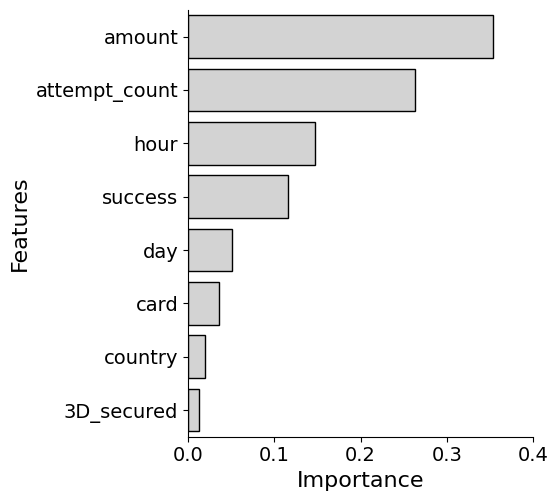

In [64]:
# Feature Importance
var_imp = pd.DataFrame({'Features': X_test.columns, 'Importance': gb_model.feature_importances_})
var_imp.sort_values('Importance', ascending = False, inplace = True)
var_imp.reset_index(inplace = True)
var_imp.drop('index', axis = 1, inplace = True)
sns.catplot(data=var_imp, y='Features', x='Importance', kind='bar', color='lightgray', edgecolor='black')
plt.xlim(0, 0.4)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('importance.pdf', bbox_inches='tight', pad_inches=.1);

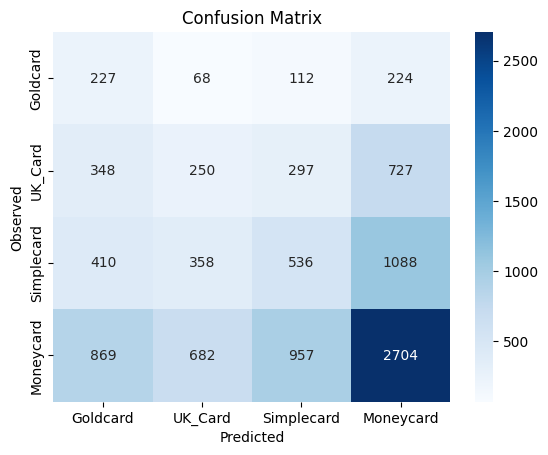

In [65]:
# Error Analysis
conf_matrix = confusion_matrix(y_test, scores_gb['Predictions'])
class_names = np.flip(y_label)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Observed');

In [66]:
# Save the best model using joblib
joblib.dump(gb_model, 'gb_model.pkl')

['gb_model.pkl']

## Business implications

### Situation before ML modelling

In [67]:
# Success rate before implementing the ML model
X_test.success.value_counts(normalize=True)

success
0    0.799026
1    0.200974
Name: proportion, dtype: float64

In [68]:
# Define the fees for each PSP
fee_structure = {
    'Goldcard': {'success': 10, 'fail': 5},
    'Moneycard': {'success': 5, 'fail': 2},
    'Simplecard': {'success': 1, 'fail': 0.5},
    'UK_Card': {'success': 3, 'fail': 1}
}

In [69]:
# Service charges calculation function
def calculate_charges(pivot_table, fee_structure):
    charges = {}
    for psp, fees in fee_structure.items():
        successful_trans = pivot_table.get(psp, {}).get(1, 0)
        failed_trans = pivot_table.get(psp, {}).get(0, 0)
        charges[psp] = {
            'Fail Charge': failed_trans*fees['fail'],
            'Success Charge': successful_trans*fees['success'],
            'Total Service Charge': (successful_trans*fees['success'])+(failed_trans*fees['fail'])
        }
    return pd.DataFrame(charges)

In [70]:
# Create a mapping dictionary from encoded values to real labels
warnings.filterwarnings('ignore')
psp_mapping = {i: label for i, label in enumerate(class_names)}

# Transactions distribution before implementing the ML model
X_test['PSP'] = y_test.map(psp_mapping)
pivot_before_ML = X_test.pivot_table(values='amount', columns='PSP', index='success', aggfunc='count', margins=True)
pivot_before_ML

PSP,Goldcard,UK_Card,Simplecard,Moneycard,All
success,,,,,
0,388,1260,2037,4191,7876
1,243,362,355,1021,1981
All,631,1622,2392,5212,9857


In [71]:
# Calculate total pre-ML service charges
charges_before_ML = calculate_charges(pivot_before_ML, fee_structure)
charges_before_ML

,Goldcard,Moneycard,Simplecard,UK_Card
Fail Charge,1940,8382,1018.5,1260
Success Charge,2430,5105,355.0,1086
Total Service Charge,4370,13487,1373.5,2346


In [72]:
# Create a DataFrame from y_test and y_pred for comparison
results_df = pd.DataFrame({
    'Actual': y_test.values.ravel(),
    'Predicted': scores_gb['Predictions'].ravel()
})
print(results_df.Actual.value_counts(normalize=True))
print(results_df.Predicted.value_counts(normalize=True))

Actual
3    0.528761
2    0.242670
1    0.164553
0    0.064015
Name: proportion, dtype: float64
Predicted
3    0.481181
2    0.192959
0    0.188090
1    0.137770
Name: proportion, dtype: float64


In [73]:
# Count the number of rows where y_test and y_pred are the same or different
same_count = (results_df['Actual'] == results_df['Predicted']).sum()
different_count = (results_df['Actual'] != results_df['Predicted']).sum()
total_count = same_count + different_count
print(f'Share of identical rows: {same_count/total_count} \nShare of different rows: {different_count/total_count}')

Share of identical rows: 0.37709242162929896 
Share of different rows: 0.622907578370701


### Situation after ML modelling

In [74]:
# Update the 'success' column in X_test based on the conditions described
X_test_updated = X_test.drop('PSP', axis=1).copy()
# Change the 'success' column to 1 where predictions differ from actual labels
X_test_updated.loc[results_df['Actual'].values != results_df['Predicted'].values, 'success'] = 1
X_test_updated

,country,amount,success,3D_secured,card,attempt_count,hour,day
18476,1,148,1,0,1,1,11,3
41858,2,137,1,1,1,4,11,5
6483,0,245,1,0,0,1,2,7
20885,1,171,0,0,2,2,13,3
3931,0,179,0,0,1,4,20,4
...,...,...,...,...,...,...,...,...
3875,0,177,1,0,1,1,3,4
6868,0,256,1,0,1,2,9,2
7028,0,262,1,0,1,1,14,3
25775,1,212,1,0,1,2,16,4


In [75]:
# Success rate after implementing the ML model
X_test_updated.success.value_counts(normalize=True)

success
1    0.684387
0    0.315613
Name: proportion, dtype: float64

In [76]:
# Transactions distribution after implementing the ML model
warnings.filterwarnings('ignore')
X_test_updated['PSP'] = y_test.map(psp_mapping)
pivot_after_ML = X_test_updated.pivot_table(values='amount', columns='PSP', index='success', aggfunc='count', margins=True)
pivot_after_ML

PSP,Goldcard,UK_Card,Simplecard,Moneycard,All
success,,,,,
0,33,235,535,2308,3111
1,598,1387,1857,2904,6746
All,631,1622,2392,5212,9857


In [77]:
# Calculate total post-ML service charges
charges_after_ML = calculate_charges(pivot_after_ML, fee_structure)
charges_after_ML

,Goldcard,Moneycard,Simplecard,UK_Card
Fail Charge,165,4616,267.5,235
Success Charge,5980,14520,1857.0,4161
Total Service Charge,6145,19136,2124.5,4396


### Comparative Analysis

In [78]:
# Comparison of the cost per transaction before and after the ML implementation
cost_per_transaction = {
    'Avg Pre-ML':{'Fail':charges_before_ML.sum(axis=1)['Fail Charge']/pivot_before_ML[pivot_before_ML.index==0]['All'][0],
                  'Success':charges_before_ML.sum(axis=1)['Success Charge']/pivot_before_ML[pivot_before_ML.index==1]['All'][1]},
    'Avg Post-ML':{'Fail':charges_after_ML.sum(axis=1)['Fail Charge']/pivot_after_ML[pivot_after_ML.index==0]['All'][0],
                   'Success':charges_after_ML.sum(axis=1)['Success Charge']/pivot_after_ML[pivot_after_ML.index==1]['All'][1]}
}

cost_per_transaction = pd.DataFrame(cost_per_transaction)
cost_per_transaction

,Avg Pre-ML,Avg Post-ML
Fail,1.599860,1.698329
Success,4.531045,3.930922


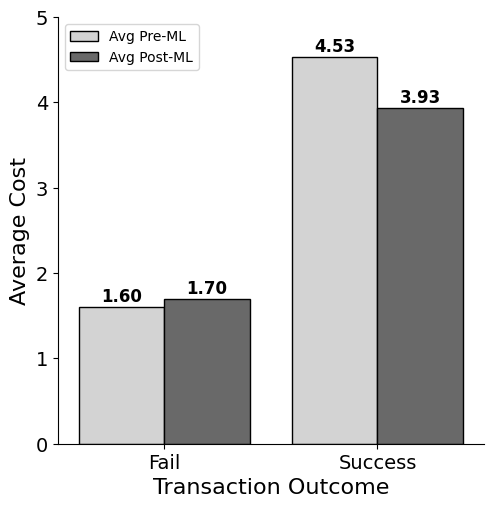

In [79]:
# Visualization
comparative_cost = pd.DataFrame(cost_per_transaction.stack()).reset_index()
comparative_cost.columns = ['Transaction Outcome', 'ML modelling', 'Average Cost']

cost_plot = sns.catplot(data=comparative_cost, x='Transaction Outcome', y='Average Cost',
                        hue='ML modelling', edgecolor='black', kind='bar', palette=gray_palette)
cost_plot._legend.remove()
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))

# Add data labels
for ax in cost_plot.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=1, size=12, weight='bold')

plt.xlabel('Transaction Outcome', fontsize=16)
plt.ylabel('Average Cost', fontsize=16)
plt.ylim(0,5)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('cost.pdf', bbox_inches='tight', pad_inches=.1);

In [80]:
# Succes Rate before and after the ML implementation
success_rate = {
    'Pre-ML': X_test.success.value_counts(normalize=True)[1],
    'Post-ML': X_test_updated.success.value_counts(normalize=True)[1]
}

success_rate = pd.DataFrame(success_rate.items(), columns=['Model Impact', 'Success Rate'])
success_rate

,Model Impact,Success Rate
0,Pre-ML,0.200974
1,Post-ML,0.684387


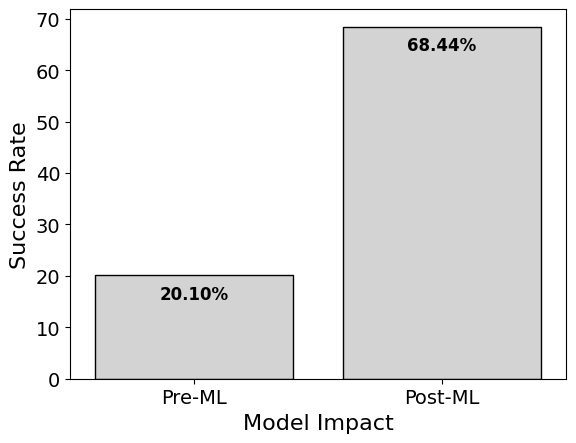

In [81]:
# Visualization
success_plot = sns.barplot(x=success_rate['Model Impact'], y=success_rate['Success Rate']*100,
                           color='lightgray', edgecolor='black')
success_plot.bar_label(success_plot.containers[0], fmt='%.2f%%', label_type='edge',
                       color='black', padding=-20, size=12, weight='bold')
plt.xlabel('Model Impact', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.savefig('success.pdf', bbox_inches='tight', pad_inches=.1);

## Deployment

In [ ]:
# Load the trained model
gb_model = joblib.load('best_gb_model.pkl')

In [ ]:
# Initialize FastAPI app
app = FastAPI()

# Define the request body schema
class PredictionRequest(BaseModel):
    success: int
    amount: float
    hour: int
    day: int
    country: int
    card: int
    attempt_count: int
    _3D_secured: int

In [ ]:
# Define the prediction endpoint
@app.post("/predict")
def predict(request: PredictionRequest):
    # Arrange the input data in the required format
    data = np.array([[
        request.success,
        request.amount,
        request.hour,
        request.day,
        request.country,
        request.card,
        request.attempt_count,
        request._3D_secured
    ]])

    # Perform the prediction
    prediction = gb_model.predict(data)
    prediction_prob = gb_model.predict_proba(data).max()

    # Return the prediction and probability
    return {
        "predicted_class": int(prediction[0]),
        "probability": float(prediction_prob)
    }

- Run the FastAPI app with the command: **uvicorn filename:app --reload**
- Link: http://127.0.0.1:8000/predict 